In [5]:
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from pandarallel import pandarallel
import spacy
import stanza
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
spacy.cli.download("pl_core_news_sm")
sns.set_theme()

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.2/20.2 MB 720.8 kB/s eta 0:00:0000:0100:01
✔ Download and installation successful
You can now load the package via spacy.load('pl_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [6]:
df = pd.read_csv('TK0409.csv')

In [7]:
def substring_to_word(s, word: str) -> str:
    index = s.find(word)
    if index == -1:
        return s 
    return s[:index]

In [8]:
df['head'] = df['raw_rulings'].apply(lambda s: substring_to_word(s, 'Trybunał'))

In [10]:
def sygn(text: str) -> str:
    match = re.search(r'\bK \d{1,2}/\d{2}\b', text)
    if match:
        return match.group()
    else:
        return ""

In [11]:
df['sygn'] = df['head'].apply(lambda s: sygn(s))

In [12]:
def typeofRuling(text: str) -> str:
    match = re.search(r"\bwyrok\b", text, re.IGNORECASE)
    if not match:
        match = re.search(r"\bpostanowienie\b", text, re.IGNORECASE)
    return match.group().lower() if match else ""

In [13]:
df['type'] = df['head'].apply(lambda s: typeofRuling(s))

In [15]:
def extractRAWDate(text: str) -> str:
    pattern = r"\b\d{1,2}\s+(stycznia|lutego|marca|kwietnia|maja|czerwca|lipca|sierpnia|września|października|listopada|grudnia)\s+\d{4}\b"
    match = re.search(pattern, text, re.IGNORECASE)
    return match.group() if match else ""

In [16]:
df['rawDate'] = df['head'].apply(lambda s: extractRAWDate(s))

In [17]:
def extractYEAR(text: str) -> str:
    pattern = r"\b\d{4}\b"
    match = re.search(pattern, text, re.IGNORECASE)
    return int(match.group()) if match else ""

In [18]:
df['year'] = df['rawDate'].apply(lambda s: extractYEAR(s))

In [19]:
miesiace = {
    'stycznia': '01',
    'lutego': '02',
    'marca': '03',
    'kwietnia': '04',
    'maja': '05',
    'czerwca': '06',
    'lipca': '07',
    'sierpnia': '08',
    'września': '09',
    'października': '10',
    'listopada': '11',
    'grudnia': '12'
}

def parse_polish_date(date_str):
    for pl, num in miesiace.items():
        if pl in date_str:
            date_str = date_str.replace(pl, num)
            break
    return pd.to_datetime(date_str, format='%d %m %Y')

In [20]:
df['dateENG'] = df['rawDate'].apply(parse_polish_date)
df = df.sort_values('dateENG', ignore_index = True)

In [22]:
def cutBefore(text: str) -> str:
    pattern = r"(UZASADNIENIE:?)(\s*\n*)"
    match = re.search(pattern, text, re.IGNORECASE)
    
    if match:
        start = match.end()
        after_marker = text[start:]
        
        if "Zdanie odrębne" in after_marker:
            before_dissent, _, _ = after_marker.partition("Zdanie odrębne")
            return before_dissent.strip()
        
        return after_marker.strip()
    
    if "UZASDNIENIE" in text:
        _, _, after_marker = text.partition("UZASDNIENIE")
        
        if "Zdanie odrębne" in after_marker:
            before_dissent, _, _ = after_marker.partition("Zdanie odrębne")
            return before_dissent.strip()
        
        return after_marker.strip()
    
    return "NAN"

In [23]:
df['grounds'] = df['raw_rulings'].apply(lambda s: cutBefore(s))

In [25]:
def cutBefore2(text: str) -> str:
    marker = "Zdanie odrębne"
    _, _, after = text.partition(marker)
    return marker + after if after else "NAN"

In [26]:
df['vot_sep'] = df['raw_rulings'].apply(lambda s: cutBefore2(s))

In [28]:
df.to_csv('TKpreprocess.csv')

In [29]:
def clean(text: str):
    cleaned_text = re.sub(r"§\s*\d+[a-z]?\.*", "", text)
    cleaned_text = re.sub(r"\b\d+[a-z]?\b\.?", "", cleaned_text)
    cleaned_text = re.sub(r'[^\w\s]', '', cleaned_text)
    return cleaned_text.lower()


pandarallel.initialize(progress_bar=True)
df['tokens_grounds'] = df['grounds'].apply(clean)
df['tokens_grounds'] = df['tokens_grounds'].parallel_apply(lambda x: nltk.word_tokenize(x))

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


In [31]:
def length(words: list):
    return len(words)

In [58]:
df['grounds_len'] = df['tokens_grounds'].apply(length)

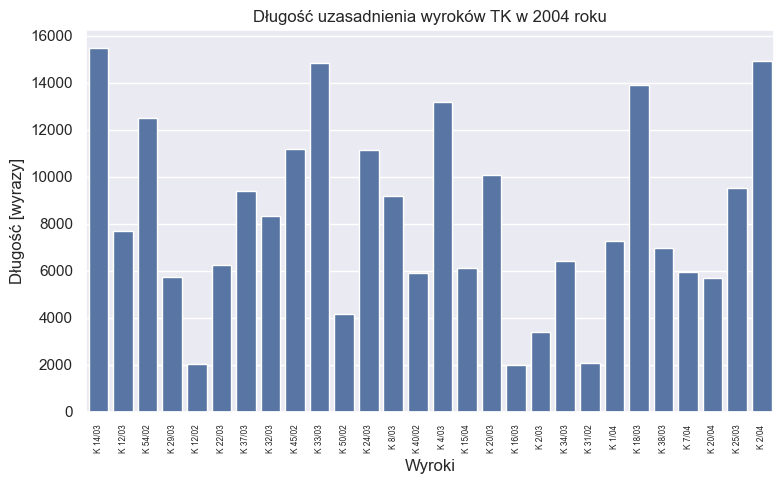

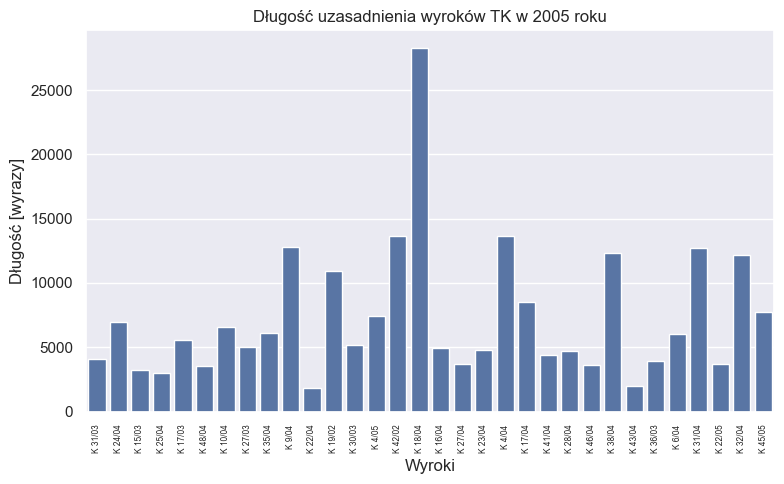

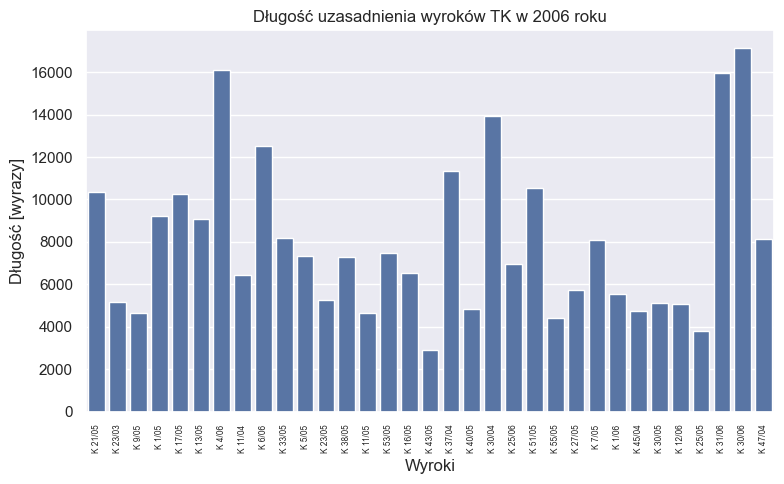

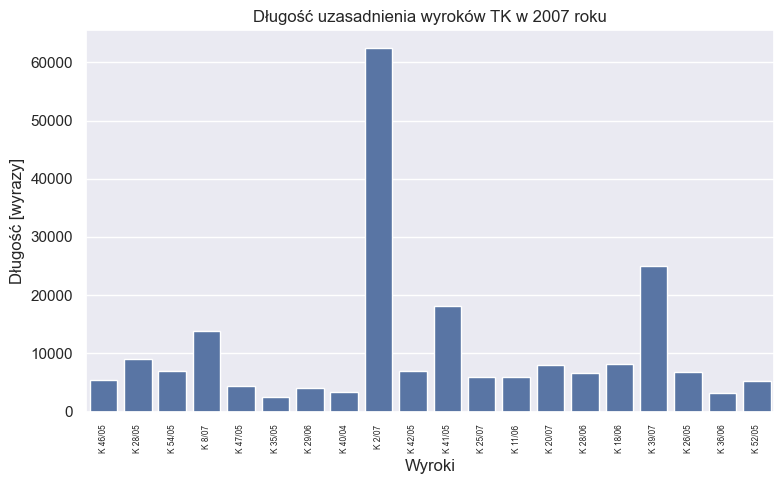

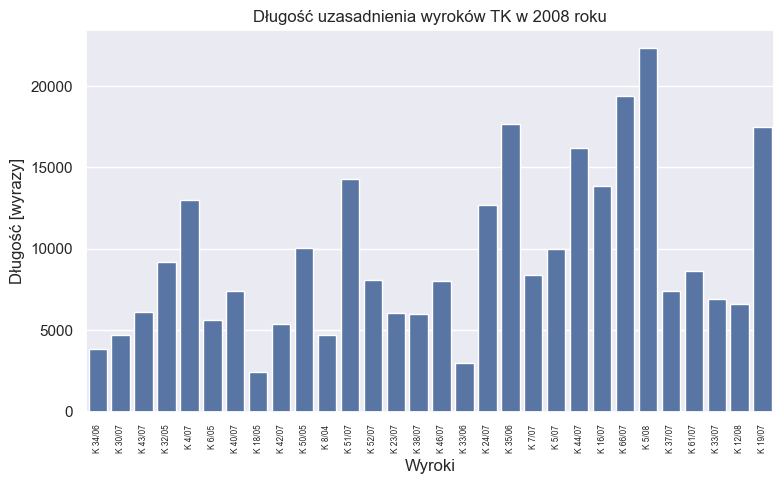

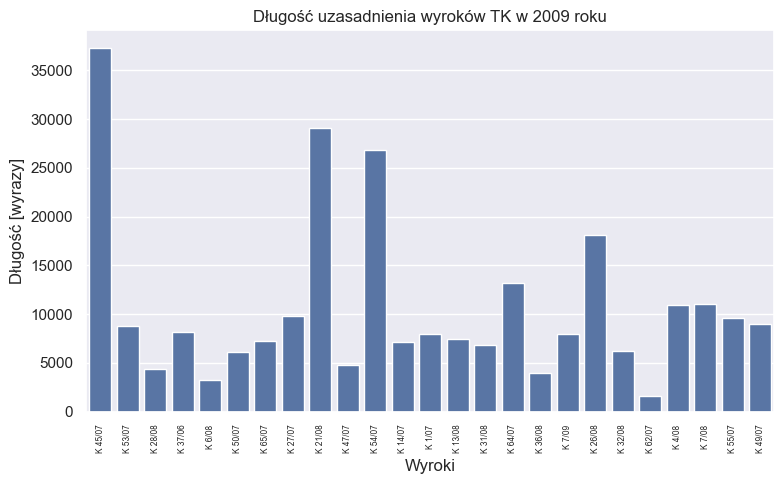

In [60]:
def plotYear(y):
    dfc = df[(df['year']==y) & (df['type']== 'wyrok')]
    plt.figure(figsize=(8, 5))
    sns.barplot(data=dfc, x='sygn', y='grounds_len')
    plt.title(f'Długość uzasadnienia wyroków TK w {y} roku')
    plt.xlabel('Wyroki')
    plt.ylabel('Długość [wyrazy]')
    plt.xticks(rotation=90, fontsize=6)
    plt.tight_layout()
    plt.show()
    
years = [2004, 2005, 2006, 2007, 2008, 2009]
for year in years:
    plotYear(year)


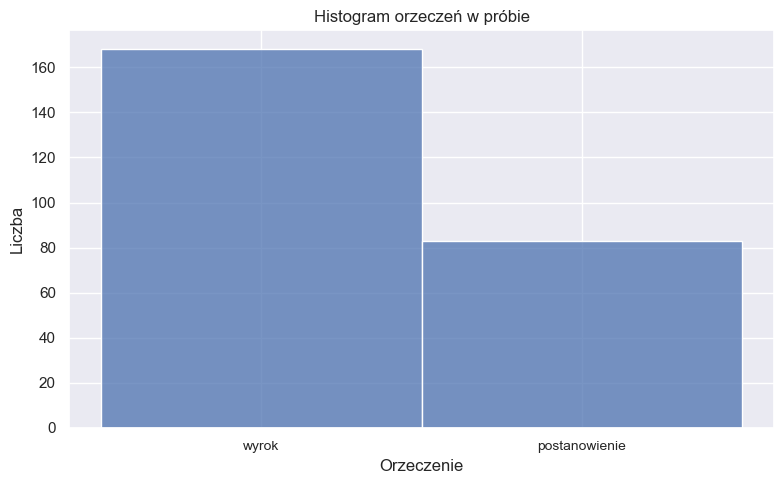

In [70]:
plt.figure(figsize=(8, 5))
sns.histplot(data=df['type'])
plt.title('Histogram orzeczeń w próbie')
plt.xlabel('Orzeczenie')
plt.ylabel('Liczba')
plt.xticks(rotation = 0, fontsize=10)
# plt.savefig("hist.png")
plt.tight_layout()
plt.show()

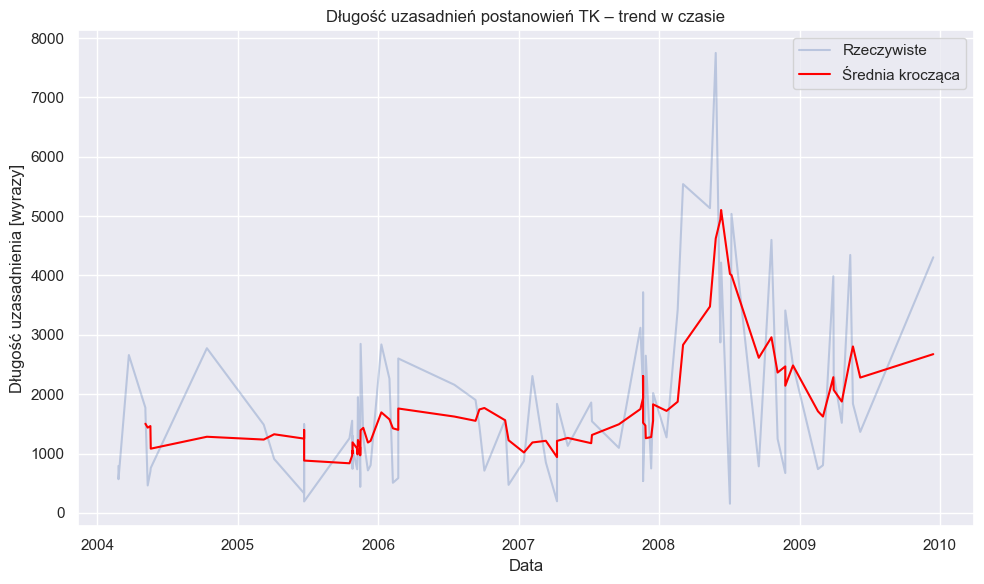

In [30]:
df_sorted = df[df['type'] == 'postanowienie'].sort_values('dateENG')  
df_sorted['rolling_mean'] = df_sorted['grounds_len'].rolling(window=5).mean()
plt.figure(figsize=(10, 6))
plt.plot(df_sorted['dateENG'], df_sorted['grounds_len'], alpha=0.3, label='Rzeczywiste')
plt.plot(df_sorted['dateENG'], df_sorted['rolling_mean'], color='red', label='Średnia krocząca')
plt.title('Długość uzasadnień postanowień TK – trend w czasie')
plt.xlabel('Data')
plt.ylabel('Długość uzasadnienia [wyrazy]')
plt.legend()
plt.tight_layout()
plt.show()

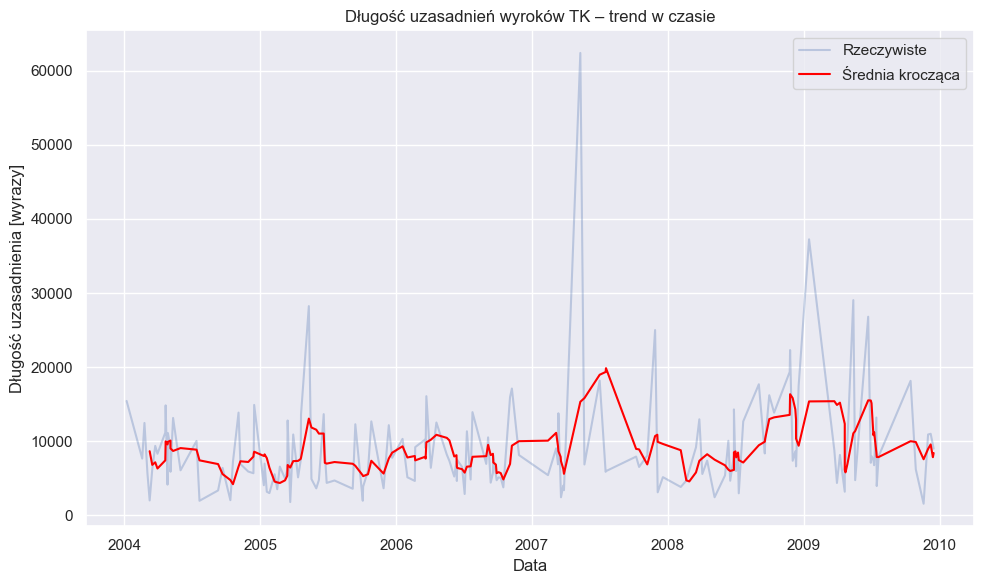

In [31]:
df_sorted = df[df['type'] == 'wyrok'].sort_values('dateENG') 
df_sorted['rolling_mean'] = df_sorted['grounds_len'].rolling(window=5).mean()
plt.figure(figsize=(10, 6))
plt.plot(df_sorted['dateENG'], df_sorted['grounds_len'], alpha=0.3, label='Rzeczywiste')
plt.plot(df_sorted['dateENG'], df_sorted['rolling_mean'], color='red', label='Średnia krocząca')
plt.title('Długość uzasadnień wyroków TK – trend w czasie')
plt.xlabel('Data')
plt.ylabel('Długość uzasadnienia [wyrazy]')
plt.legend()
plt.tight_layout()
plt.show()

/var/folders/sn/3fp31rj12dnfk_ggs5y20bd80000gn/T/ipykernel_50460/1451394215.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=mean, palette = my_pal)


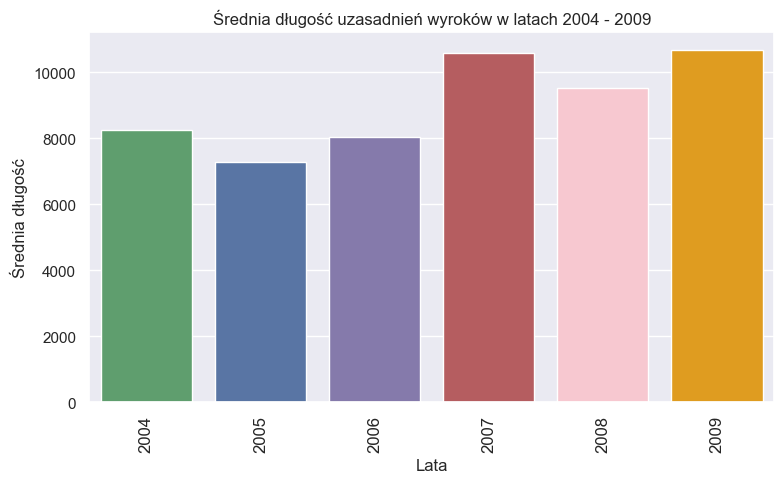

In [32]:
mean = df[df['type'] == 'wyrok'].groupby('year')['grounds_len'].mean()
my_pal = {"2004": "g", "2005": "b", "2006":"m", "2007": "r", "2008": "pink","2009": "orange" }
plt.figure(figsize=(8, 5))
sns.barplot(data=mean, palette = my_pal)
plt.title('Średnia długość uzasadnień wyroków w latach 2004 - 2009')
plt.xlabel('Lata')
plt.ylabel('Średnia długość')
plt.xticks(rotation=90, fontsize=12)
plt.tight_layout()
plt.show()


/var/folders/sn/3fp31rj12dnfk_ggs5y20bd80000gn/T/ipykernel_50460/3657724475.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df[df['type'] == 'postanowienie'], x='year', y='grounds_len', palette = my_pal)


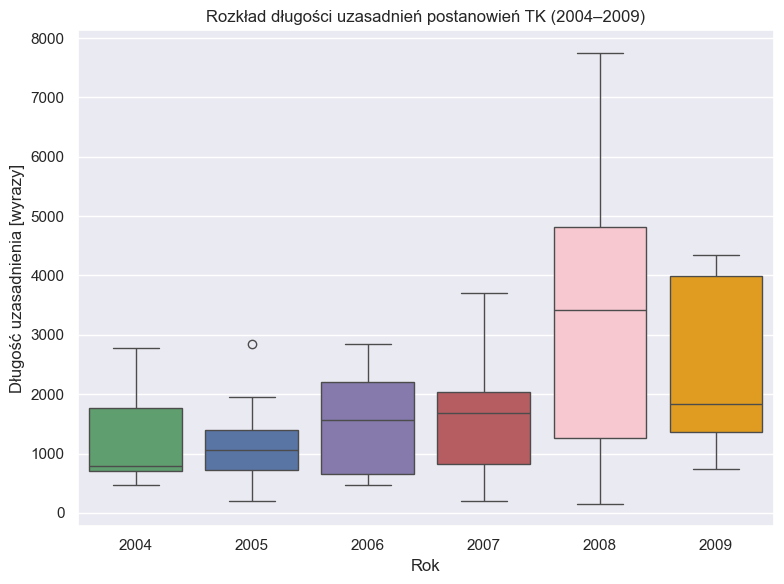

In [33]:
my_pal = {"2004": "g", "2005": "b", "2006":"m", "2007": "r", "2008": "pink","2009": "orange" }
plt.figure(figsize=(8, 6))
sns.boxplot(data=df[df['type'] == 'postanowienie'], x='year', y='grounds_len', palette = my_pal)
plt.title('Rozkład długości uzasadnień postanowień TK (2004–2009)')
plt.xlabel('Rok')
plt.ylabel('Długość uzasadnienia [wyrazy]')
plt.tight_layout()
plt.show()

/var/folders/sn/3fp31rj12dnfk_ggs5y20bd80000gn/T/ipykernel_50460/3957084993.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df[df['type'] == 'wyrok'], x='year', y='grounds_len', palette = my_pal)


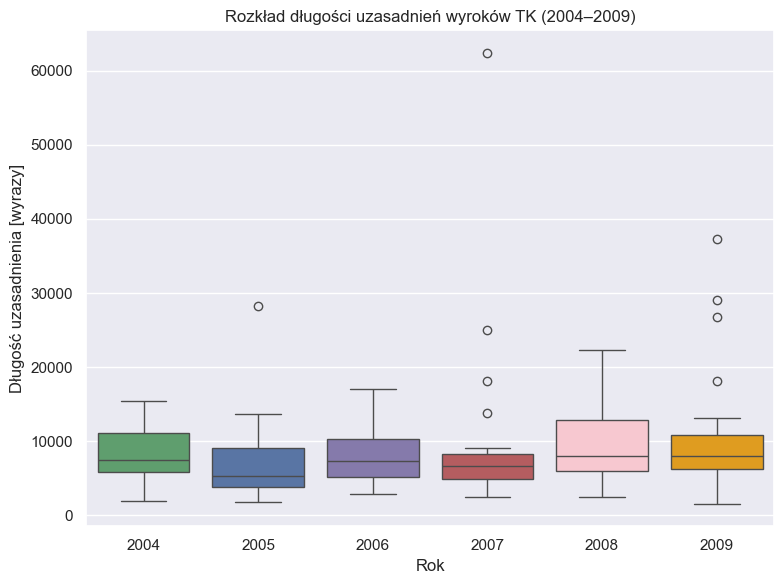

In [34]:
my_pal = {"2004": "g", "2005": "b", "2006":"m", "2007": "r", "2008": "pink","2009": "orange" }
plt.figure(figsize=(8, 6))
sns.boxplot(data=df[df['type'] == 'wyrok'], x='year', y='grounds_len', palette = my_pal)
plt.title('Rozkład długości uzasadnień wyroków TK (2004–2009)')
plt.xlabel('Rok')
plt.ylabel('Długość uzasadnienia [wyrazy]')
plt.tight_layout()
plt.show()

In [35]:
pandarallel.initialize(progress_bar=True)
df['votsep_ratio'] = df['vot_sep'].apply(clean)
df['votsep_ratio'] = df['votsep_ratio'].parallel_apply(lambda x: nltk.word_tokenize(x))
df['votsep_len'] = df['votsep_ratio'].apply(length)

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


             votsep_len  grounds_len
votsep_len     1.000000     0.891694
grounds_len    0.891694     1.000000


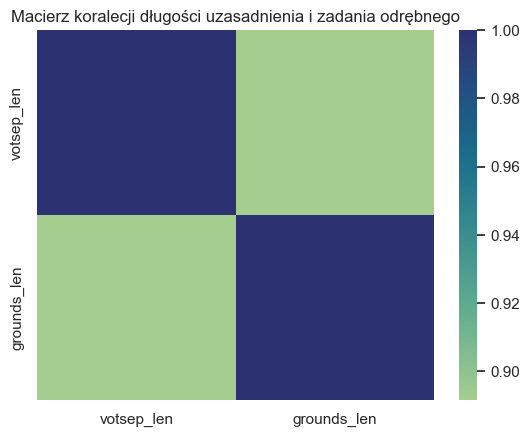

In [36]:
dfN = df[['votsep_len', 'grounds_len']]
dfNc = dfN[dfN['votsep_len'] > 1]
corr = dfNc.corr()
print(corr)
sns.heatmap(data = corr, cmap="crest")
plt.title('Macierz koralecji długości uzasadnienia i zadania odrębnego')
plt.show()

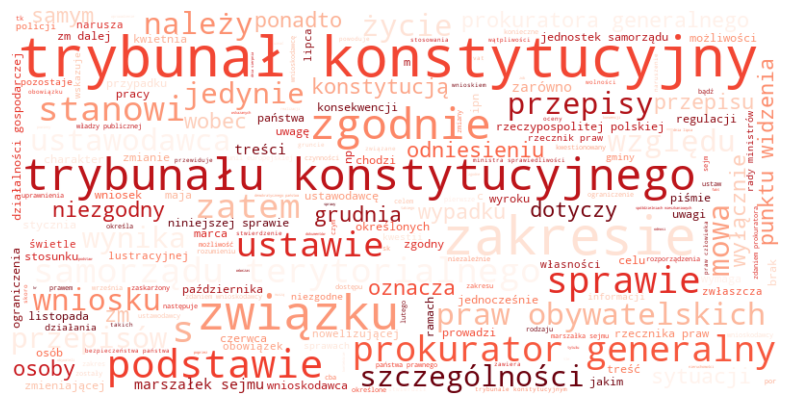

In [78]:
df['grounds'] = df['grounds'].apply(lambda s : s.lower())

all_text = " ".join(df['grounds'].dropna().tolist())

words = []
with open('polish.stopwords.txt', encoding='utf-8') as f:
    words = f.read().splitlines()
stopwords = set(STOPWORDS)
stopwords.update(words)
extra = ['ust', 'nr', 'poz', 'ust ustawy', 'ust konstytucji', 'ust', 'pkt ustawy', 'pkt', 'zaś', 'dz', 'sygn', 'otk', 'zu', 'tj', 'p']
for w in extra:
    stopwords.add(w)


wordcloud = WordCloud(width=800, height=400, background_color='white',colormap = "viridis", stopwords=stopwords).generate(all_text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.savefig('chmura2.png')
plt.show()